# Tutoriel sur le package StepMix
## Adapté du [tutoriel de Sacha Morin](https://colab.research.google.com/drive/1KAxcvxjL_vB2lAG9e47we7hrf_2fR1eK?usp=sharing#scrollTo=purSLTpt8TQx)
### Charles-Édouard Giguère
### 2023-05-25

# 1. Analyse sur des données continues.

Dans ce tutoriel, je reproduis les exemples du package stepmix pour
tester toutes les options du package et vérifier qu'elle fonctionne
avec stepmixr. J'ai ajouté des lignes de code pour visualiser les
résultats et voir comment on pourrait utiliser le package en contexte
pratique.

## Importation des packages
On importe les packages nécessaires pour faire rouler les exemples.

In [2]:
from stepmix.stepmix import StepMix
from stepmix.datasets import data_bakk_response, data_bakk_covariate
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import rand_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from stepmix.utils import get_mixed_descriptor, print_report
from scipy.stats import norm

Chargement du fichier de données iris.
Le fichier est importé du package sklearn.
L'objet `df` est un data frame pandas (options `as_frame=True`)
l'objet `target` est aussi un data frame pandas.

In [3]:
df, target = load_iris(return_X_y=True, as_frame=True)

In [4]:
# Save actual flower type name
# On peut ajouter le nom des fleurs dans le df qui contient
# les données morphologiques de l'iris.
# Essentiellement, on a la largeur et longueur des pétales et sépales pour
# trois types de fleurs. 50 spécimens pour chaque type (150 spécimens)
df['iris_flower_type'] = target.map({0: 'setosa',
                                     1: 'versicolor',
                                     2: 'virginica'})

On peut afficher pour les sépales et pétales séparément
un graphique qui montre les longueurs sur les largeurs.
La couleur illustre les trois types de fleurs.
La séparation des trois espèces est assez claire; l'algorithme
devrait donc reproduire la structure assez facilement.

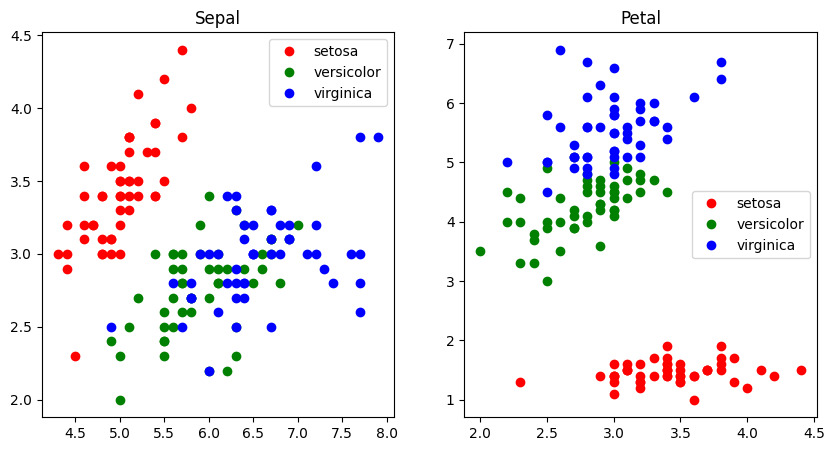

In [5]:
plt.rcParams['figure.figsize'] = [10, 5]
col_iris = ['red', 'green', 'blue']
species = ['setosa', 'versicolor', 'virginica']
fig, ax = plt.subplots(ncols=2)
for i in np.arange(0, 3):
    ax[0].plot(df[target == i].iloc[:, 0], df[target == i].iloc[:, 1],
               "o", color=col_iris[i], label=species[i])
    ax[1].plot(df[target == i].iloc[:, 1], df[target == i].iloc[:, 2],
               "o", color=col_iris[i], label=species[i])
ax[0].set_title("Sepal")
ax[1].set_title("Petal")
ax[0].legend()
ax[1].legend()
plt.show()

On crée maintenant un modèle stepmix qu'on ajuste et qu'on
fit au jeu de données iris.

In [6]:
model = StepMix(n_components=3, measurement="continuous",
                verbose=1, random_state=123)

In [7]:
model.fit(df.iloc[:, 0:4])
print_report(model, df.iloc[:, 0:4])

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████████| 1/1 [00:00<00:00, 20.89it/s, max_LL=-307, max_avg_LL=-2.05]

MODEL REPORT
    Measurement model parameters
          model_name                    gaussian_diag                
          class_no                                  0       1       2
          param       variable                                       
          covariances petal length (cm)        0.0296  0.2254  0.3269
                      petal width (cm)         0.0109  0.0348  0.0851
                      sepal length (cm)        0.1218  0.2288  0.3246
                      sepal width (cm)         0.1408  0.0870  0.0827
          means       petal length (cm)        1.4620  4.2225  5.4829
                      petal width (cm)         0.2460  1.3044  1.9896
                      sepal length (cm)        5.0060  5.8346  6.6227
                      sepal width (cm)         3.4280  2.7001  3.0171
    Class weights
        Class 1 : 0.33
        Class 2 : 0.31
        Class 3 : 0.36
    Fit for 3 latent classes
    Estimation method             : 1-step
    Number of observation

On sauvegarde maintenant les prédictions de l'appartenance
au groupe.

In [8]:
df['Class.Membership'] = model.predict(df.iloc[:, 0:4])
df['Class.Membership'].value_counts()

Class.Membership
2    55
0    50
1    45
Name: count, dtype: int64

<BarContainer object of 3 artists>

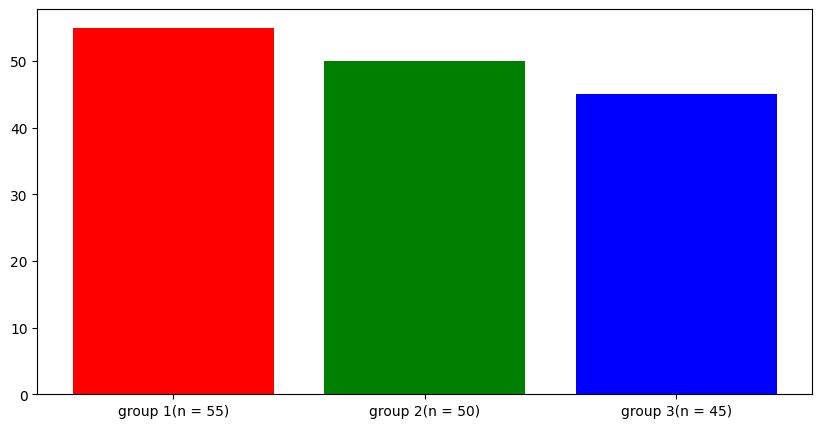

In [9]:
# On affiche un bar plot de l'attribution dans chaque classe.
tab_mod1 = df['Class.Membership'].value_counts()
groups_mod1 = ['group 1', 'group 2', 'group 3']
groups_mod1 = [i + "(n = {}".format(j) + ")"
               for i, j in zip(groups_mod1, tab_mod1)]
plt.bar(groups_mod1, height=tab_mod1, color=['r', 'g', 'b'])

On peut comparer les espèces de fleur aux classes trouvées selon
les caractéristiques seulement. On constate que 95% des données
correspondent aux valeurs originales.

In [10]:
pd.crosstab(df['Class.Membership'], df['iris_flower_type'])

iris_flower_type,setosa,versicolor,virginica
Class.Membership,,,
0,50,0,0
1,0,43,2
2,0,7,48


On peut aussi examiner les valeurs des probabilités a posteriori.

In [11]:
post_prob_mod1 = model.predict_proba(df.iloc[:, 0:4])

Pourquoi certaines classes attribuées ne correspondent pas à leur
classe?
Affichons les points qui n'ont pas un match parfait avec l'espace.
On peut voir que la probabilité d'appartenance est plus basse car
il s'agit de points à la frontière des caractéristiques de deux
espèces.

In [12]:
post_prob_mod1[df['Class.Membership'] != target, 0:4]

array([[4.07078321e-109, 2.63794038e-001, 7.36205962e-001],
       [1.32994386e-123, 9.39815321e-002, 9.06018468e-001],
       [2.39720112e-115, 2.28801087e-001, 7.71198913e-001],
       [2.04750573e-130, 4.04024347e-002, 9.59597565e-001],
       [7.26055600e-139, 1.38125520e-002, 9.86187448e-001],
       [2.34274625e-135, 4.77858704e-001, 5.22141296e-001],
       [1.58480342e-112, 3.54099900e-001, 6.45900100e-001],
       [2.55723085e-109, 9.85435164e-001, 1.45648357e-002],
       [6.36832789e-126, 9.74024383e-001, 2.59756167e-002]])

Les points qui sont classées dans un groupe différent de leur espèce
d'origine sont identifiés par des carrés. On peut les retrouver à la
frontière des deux espèces versicolor et virginica.

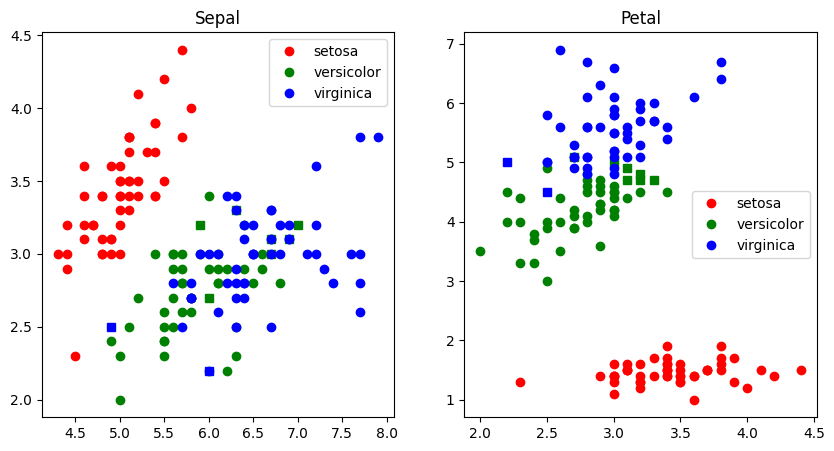

In [13]:
plt.rcParams['figure.figsize'] = [10, 5]
col_iris = ['red', 'green', 'blue']
species = ['setosa', 'versicolor', 'virginica']
fig, ax = plt.subplots(ncols=2)
for i in np.arange(0, 3):
    df_filtre = df[(target == i) & (target == df['Class.Membership'])]
    df_filtre1 = df[(target == i) & (target != df['Class.Membership'])]
    ax[0].plot(df_filtre.iloc[:, 0], df_filtre.iloc[:, 1],
               "o", color=col_iris[i], label=species[i])
    ax[1].plot(df_filtre.iloc[:, 1], df_filtre.iloc[:, 2],
               "o", color=col_iris[i], label=species[i])
    ax[0].plot(df_filtre1.iloc[:, 0], df_filtre1.iloc[:, 1],
               "s", color=col_iris[i])
    ax[1].plot(df_filtre1.iloc[:, 1], df_filtre1.iloc[:, 2],
               "s", color=col_iris[i])
ax[0].set_title("Sepal")
ax[1].set_title("Petal")
ax[0].legend()
ax[1].legend()
plt.show()

Finalement, on peut voir que le rand score est très élevé.

In [14]:
rand_score(target, df['Class.Membership'])

0.9267114093959732

# 2. Analyses sur des données dichotomiques.

Création de données dichotomiques basées sur les quantiles.

In [15]:
binary_features = []
for c in df.iloc[:, 0:4]:
    c_binary = c.replace("cm", "q=2")
    binary_features.append(c_binary)
    df[c_binary] = pd.qcut(df[c], q=2).cat.codes

Sélectionner les colonnes and montrer le `data.frame`.

In [16]:
binary_data = df[binary_features]

In [17]:
binary_data.to_csv("iris_bin.csv")
binary_data['sepal length (q=2)'].value_counts()
binary_data.iloc[:, 1].value_counts()
binary_data.iloc[:, 2].value_counts()

petal length (q=2)
0    75
1    75
Name: count, dtype: int64

On fait le modèle et on ajuste les données au jeux de données
binaires. On extrait ensuite l'attribution dans les groupes.

In [18]:
model = StepMix(n_components=3, measurement="binary",
                verbose=1, random_state=123)
model.fit(binary_data)
df['binary_pred'] = model.predict(binary_data)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████████| 1/1 [00:00<00:00, 14.95it/s, max_LL=-268, max_avg_LL=-1.79]

MODEL REPORT
    Measurement model parameters
          model_name                binary                
          class_no                       0       1       2
          param variable                                  
          pis   petal length (q=2)  0.8580  0.0000  1.0000
                petal width (q=2)   0.7426  0.0000  1.0000
                sepal length (q=2)  0.5618  0.0379  1.0000
                sepal width (q=2)   0.0000  0.5890  0.4744
    Class weights
        Class 1 : 0.17
        Class 2 : 0.48
        Class 3 : 0.35
    Fit for 3 latent classes
    Estimation method             : 1-step
    Number of observations        : 150
    Number of latent classes      : 3
    Number of estimated parameters: 14
    Log-likelihood (LL)           : -267.7836
    -2LL                          : 535.5672
    Average LL                    : -1.7852
    AIC                           : 563.57
    BIC                           : 605.72
    CAIC                          : 619.72
 

On peut voir que le type de fleur n'est pas aussi bien prédit
et que le rand_score n'est pas aussi bon. Ceci est attendu car
en dichotomisant on perd de l'information.

In [19]:
pd.crosstab(df['iris_flower_type'], df['binary_pred'])
rand_score(df['iris_flower_type'], df['binary_pred'])

0.7276957494407159

In [20]:
binary_means = model.get_parameters()["measurement"]

Les paramètres sont bornés de 0 à 1 car ils représentent la probabilité
que le feature soit 1 (par rapport à la référence de 0).

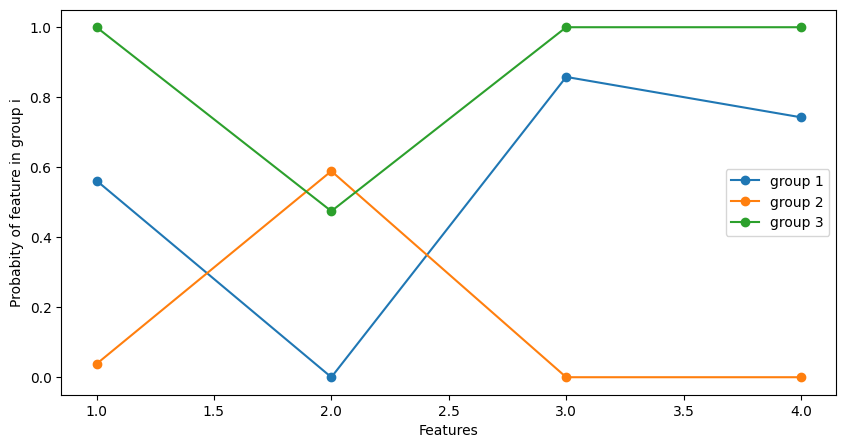

In [21]:
for i in range(3):
    plt.plot(np.arange(1, 5), binary_means['pis'][i, :], "-o",
             label="group {}".format(i + 1))
plt.xlabel('Features')
plt.ylabel('Probabity of feature in group i')
plt.legend()
plt.show()

# 3. Analyses sur des données catégorielles.
on reprend l'exemple continue en séparant en trois catégories
ordonnées.

In [22]:
categorical_features = []
continuous_data = df.iloc[:, 0:4]
for c in continuous_data:
    # Create new column name
    c_categorical = c.replace("cm", "q=3")
    categorical_features.append(c_categorical)
    df[c_categorical] = pd.qcut(df[c], q=3).cat.codes

sélection des quatres colonnes catégorielles. À noter que les
colonnes sont indexées 0, 1, 2

In [23]:
categorical_data = df[categorical_features]
categorical_data
categorical_data.to_csv("iris_cat.csv")

On ajuste le modèle avec l'option catégorielle, on fait l'ajustement
du modèle et on prédit l'appartenance au trois catégories.

In [24]:
model = StepMix(n_components=3, measurement="categorical",
                verbose=1, random_state=123)
model.fit(categorical_data)
df['categorical_pred'] = model.predict(categorical_data)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████████| 1/1 [00:00<00:00, 29.02it/s, max_LL=-412, max_avg_LL=-2.75]

MODEL REPORT
    Measurement model parameters
          model_name                 categorical                
          class_no                             0       1       2
          param variable                                        
          pis   petal length (q=3)_0        1.00  0.0000  0.0000
                petal length (q=3)_1        0.00  0.0000  0.9124
                petal length (q=3)_2        0.00  1.0000  0.0876
                petal width (q=3)_0         1.00  0.0000  0.0000
                petal width (q=3)_1         0.00  0.0141  0.8689
                petal width (q=3)_2         0.00  0.9859  0.1311
                sepal length (q=3)_0        0.90  0.0000  0.1183
                sepal length (q=3)_1        0.10  0.2310  0.7024
                sepal length (q=3)_2        0.00  0.7690  0.1793
                sepal width (q=3)_0         0.04  0.3287  0.7026
                sepal width (q=3)_1         0.30  0.4760  0.2631
                sepal width (q=3)_2         

On change les catégories de références afin de correspondre aux espèces.

In [25]:
df['categorical_pred'] = np.array([0, 2, 1])[df['categorical_pred']]

On peut voir que l'organisation des classes est très bonne. Le rand score
se situe entre la prédiction en continue et celle dichotomique.

In [26]:
pd.crosstab(df['iris_flower_type'], df['categorical_pred'])

categorical_pred,0,1,2
iris_flower_type,,,
setosa,50,0,0
versicolor,0,49,1
virginica,0,10,40


In [27]:
rand_score_models = np.array(
    [rand_score(df['iris_flower_type'], df['binary_pred']),
     rand_score(df['iris_flower_type'], df['categorical_pred']),
     rand_score(df['iris_flower_type'], df['Class.Membership'])])

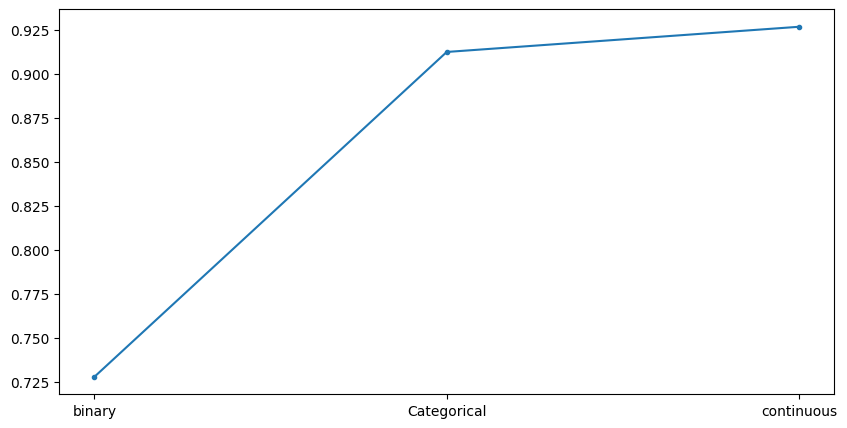

In [28]:
plt.plot(['binary', 'Categorical', 'continuous'], rand_score_models,
         ".-")

# 4. Analyses sur des données de types mélangés

La fonction suivante permet de faire un modèle utilisant des données
de plusieurs types différents. Le fichier mixed_data contient les
données et le fichier mixed_descriptor l'information sur le type associé
à chaque colonne.

In [29]:
mixed_data, mixed_descriptor = get_mixed_descriptor(
    dataframe=df,
    continuous=['sepal length (cm)', 'petal length (cm)'],
    binary=['petal width (q=2)'],
    categorical=['sepal width (q=3)']
)

In [30]:
# On ajuste le modèle avec deux variables continues, une variable dichotomique
# et une variable catégorielle.
model = StepMix(n_components=3, measurement=mixed_descriptor,
                verbose=1, random_state=123)

In [31]:
model.fit(mixed_data)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████████| 1/1 [00:00<00:00, 37.43it/s, max_LL=-437, max_avg_LL=-2.92]

MODEL REPORT
    Measurement model parameters
          model_name                    continuous                
          class_no                               0       1       2
          param       variable                                    
          covariances petal length (cm)     0.0296  0.1645  0.3945
                      sepal length (cm)     0.1218  0.1739  0.3306
          means       petal length (cm)     1.4620  4.0062  5.2945
                      sepal length (cm)     5.0060  5.6694  6.5179


          model_name              binary             
          class_no                     0       1    2
          param variable                             
          pis   petal width (q=2)    0.0  0.0716  1.0


          model_name                categorical                
          class_no                            0       1       2
          param variable                                       
          pis   sepal width (q=3)_0        0.04  0.9282  0.3867
         

StepMix(measurement={'binary': {'model': 'binary', 'n_columns': 1},
                     'categorical': {'model': 'categorical', 'n_columns': 1},
                     'continuous': {'model': 'continuous', 'n_columns': 2}},
        n_components=3, random_state=123, verbose=1)

In [32]:
df['mixed_pred'] = model.predict(mixed_data)

Voici le tableau croisé avec les espèces et le rand score.

In [33]:
pd.crosstab(df['iris_flower_type'], df['mixed_pred'])

mixed_pred,0,1,2
iris_flower_type,,,
setosa,50,0,0
versicolor,0,29,21
virginica,0,1,49


In [34]:
rand_score(df['iris_flower_type'], df['mixed_pred'])

0.8464429530201343

# 5. Analyses incluant des données manquantes (type = continue)

Ici, on recopie les données en continue et on génère
des données manquantes (20 %)

In [35]:
continuous_data_nan = continuous_data.copy()
for i, c in enumerate(continuous_data_nan.columns):
    continuous_data_nan[c] = continuous_data_nan[c].sample(frac=.8,
                                                           random_state=42 * i)

In [36]:
continuous_data_nan

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,NaN,1.4,NaN
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,NaN
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,NaN,3.0,NaN,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,NaN,2.0
148,6.2,3.4,5.4,2.3


In [37]:
continuous_data_nan.to_csv("continuous_data_nan.csv")

Comme toujours, on crée le modèle, on l'ajuste et on fait la prédiction.

In [38]:
model = StepMix(n_components=3, measurement="continuous_nan",
                verbose=1, random_state=123)
model.fit(continuous_data_nan)
df['continuous_pred_nan'] = model.predict(continuous_data_nan)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████████| 1/1 [00:00<00:00,  7.82it/s, max_LL=-267, max_avg_LL=-1.78]

MODEL REPORT
    Measurement model parameters
          model_name                    gaussian_diag_nan                
          class_no                                      0       1       2
          param       variable                                           
          covariances petal length (cm)            0.0324  0.1959  0.3646
                      petal width (cm)             0.0113  0.0268  0.1045
                      sepal length (cm)            0.1217  0.2021  0.2963
                      sepal width (cm)             0.1185  0.0894  0.0987
          means       petal length (cm)            1.4591  4.1131  5.4208
                      petal width (cm)             0.2419  1.2665  1.9219
                      sepal length (cm)            4.9872  5.7368  6.5665
                      sepal width (cm)             3.4327  2.6527  3.0039
    Class weights
        Class 1 : 0.34
        Class 2 : 0.26
        Class 3 : 0.40
    Fit for 3 latent classes
    Estimation method   

On compare les prédictions aux espèces originales.

In [39]:
pd.crosstab(df['iris_flower_type'], df['continuous_pred_nan'])

continuous_pred_nan,0,1,2
iris_flower_type,,,
setosa,50,0,0
versicolor,1,36,13
virginica,0,2,48


In [40]:
rand_score(df['iris_flower_type'], df['continuous_pred_nan'])

0.8783892617449665

# 6. Modèle structurelle: Classe + prédictions

On simule les données selon les modèles présentés dans l'article
de Zsuzsa Bakk.

- X contient les données sur lesquels on ajuste les classes latentes
- y est la variable dépendante (composante structurelle).
- target contient les "vrais" valeurs de groupes.

In [41]:
X, y, target = data_bakk_response(n_samples=2000,
                                  sep_level=.9, random_state=42)

In [42]:
# On crée le modèle, on ajuste aux données X et Y.
model = StepMix(n_components=3, measurement='binary',
                structural='gaussian_unit', verbose=1,
                random_state=123)

In [43]:
model.fit(X, y)

Fitting StepMix...


Initializations (n_init) : 100%|████████████████████████| 1/1 [00:00<00:00, 17.47it/s, max_LL=-8.6e+3, max_avg_LL=-4.3]

MODEL REPORT
    Measurement model parameters
          model_name       binary                
          class_no              0       1       2
          param variable                         
          pis   feature_0  0.9024  0.0928  0.9028
                feature_1  0.9108  0.1044  0.8996
                feature_2  0.9039  0.1024  0.8978
                feature_3  0.8992  0.0832  0.1156
                feature_4  0.9034  0.0885  0.0756
                feature_5  0.9080  0.0962  0.1004
    Structural model parameters
          model_name      gaussian_unit                
          class_no                    0       1       2
          param variable                               
          means feature_0       -1.0153 -0.0379  0.9599
    Class weights
        Class 1 : 0.32
        Class 2 : 0.34
        Class 3 : 0.34
    Fit for 3 latent classes
    Estimation method             : 1-step
    Number of observations        : 2000
    Number of latent classes      : 3
    Number

StepMix(measurement='binary', n_components=3, random_state=123, verbose=1)

On peut comparer les classes obtenues aux prédictions.

In [44]:
preds = model.predict(X, y)
pd.Series(preds).value_counts()
preds2 = np.array([0, 2, 1])[preds]
pd.Series(preds2).value_counts()

1    675
2    674
0    651
Name: count, dtype: int64

In [45]:
preds_ctabs = pd.crosstab(target, preds2)
preds_ctabs

col_0,0,1,2
row_0,,,
0,637,9,3
1,12,649,16
2,2,17,655


In [46]:
preds_pgood = sum(np.diag(preds_ctabs)) / sum(sum(preds_ctabs.values)) * 100
print("{} % de bonne prédiction".format(preds_pgood))

97.05 % de bonne prédiction


On s'intéresse aussi à la prédiction de la valeur y.
Les valeurs représente la moyenne de ces valeurs dans chaque
groupe.

In [47]:
model.get_parameters()['structural']

{'means': array([[-1.01526771],
        [-0.03792965],
        [ 0.95994092]])}

Normalement, dans une régression on voudrait avoir des erreurs-types (se)
et des p-values associées à des tests pour confirmer qu'il y a des
différence entre les moyennes. Dans stepmix, on peut faire cela à l'aide du
bootstrapping. Pour l'instant, on ne fait qu'afficher le résultat et
la méthode de bootstrapping est présenté à la section 11. On peut voir une
grande séparation entre les moyennes (la séparation dans les données étaient
de 0.9).

Text(0, 0.5, 'Moyennes de y')

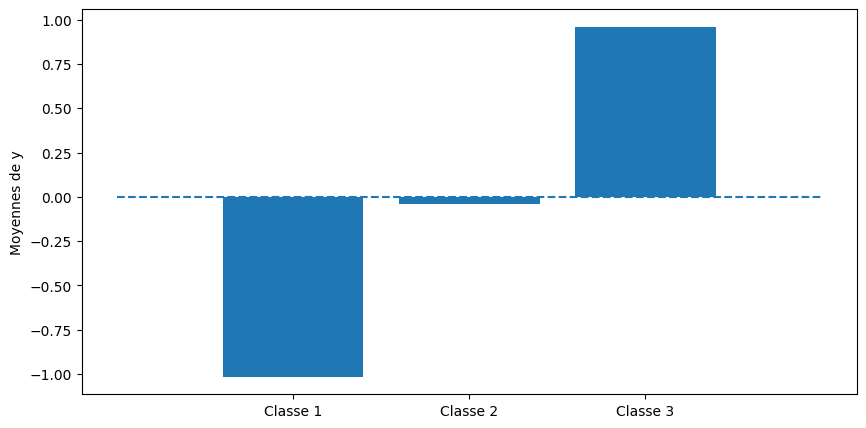

In [48]:
plt.bar(['Classe 1', 'Classe 2', 'Classe 3'],
        height=model.get_parameters()['structural']['means'][:, 0])
plt.plot([-1, 3], [0, 0], "--")
plt.ylabel("Moyennes de y")

# 7. modèle structurel: classes + prédicteurs de classe.

In [49]:
# On simule les données selon les modèles présentés dans l'article
# de Zsuzsa Bakk.
# X contient les données pour les classes latentes.
# y est le prédicteur de classe.
# target are ground truth class memberships
X, y, target = data_bakk_covariate(n_samples=2000, sep_level=.9,
                                   random_state=42)

In [50]:
X
# Le modèle avec covariable a une procédure interne dans laquelle on peut
# ajouter des arguments supplémentaires comme le taux d'apprentissage et
# la méthode d'optimisation. Dans cet exemple on utilise l'algorithme de
# Newton-Raphson et on inclue un intercept dans le modèle.

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])

In [51]:
opt_params = {
    'method': 'newton-raphson',  # Can also be "gradient",
    'intercept': True,
    'max_iter': 1,  # Number of opt. step each time we update the model
}

On définit le modèle et on l'ajuste au données.

In [52]:
model = StepMix(n_components=3, measurement='binary',
                structural='covariate', structural_params=opt_params,
                verbose=1, random_state=123)
# Fit data
# Provide both measurement data X and structural data Y
model.fit(X, y)

Fitting StepMix...


Initializations (n_init) : 100%|███████████████████████| 1/1 [00:00<00:00, 13.11it/s, max_LL=-5.19e+3, max_avg_LL=-2.6]

MODEL REPORT
    Measurement model parameters
          model_name       binary                
          class_no              0       1       2
          param variable                         
          pis   feature_0  0.0935  0.9015  0.9059
                feature_1  0.1079  0.9084  0.8961
                feature_2  0.0991  0.9006  0.9041
                feature_3  0.0863  0.9034  0.1087
                feature_4  0.0868  0.8993  0.0771
                feature_5  0.0986  0.9111  0.0972
    Structural model parameters
          model_name      covariate                
          class_no                0       1       2
          param variable                           
          beta  feature_0    1.0375  0.0111 -1.0494
                intercept   -3.2897  0.4457  2.8436
    Class weights
        Class 1 : 0.34
        Class 2 : 0.33
        Class 3 : 0.33
    Fit for 3 latent classes
    Estimation method             : 1-step
    Number of observations        : 2000
    Number o

StepMix(measurement='binary', n_components=3, random_state=123,
        structural='covariate',
        structural_params={'intercept': True, 'max_iter': 1,
                           'method': 'newton-raphson'},
        verbose=1)

On compare nos classes aux "vrais" classes.

In [53]:
preds = model.predict(X, y)
preds2 = np.array([2, 0, 1])[preds]
pd.crosstab(target, preds2)

col_0,0,1,2
row_0,,,
0,650,14,4
1,15,624,12
2,2,10,669


Voici la façon d'extraire les betas et les prédictions de
probabilités *a priori*. On peut voir qu'il faut faire une tranformation
pour obtenir un beta normalisé.

In [54]:
BETA = model.get_parameters()['structural']['beta']
# On met la catégorie 1 comme référence.
BETA -= BETA[0, :].reshape((1, -1))
BETA

array([[ 0.        ,  0.        ],
       [ 3.73533966, -1.02634583],
       [ 6.13331852, -2.08685907]])

Voici comment la prédiction est faite. Je prends seulement les 5
premières rangées.
1. On calcule une matrice de design.

In [55]:
XX = np.column_stack((np.repeat(1, 5), y[0:5]))
XX

array([[1, 4],
       [1, 5],
       [1, 3],
       [1, 5],
       [1, 5]])

2. On multiplie X par beta.

In [56]:
la = np.dot(XX, BETA.transpose())

3. Pour chaque rangée, on calcule
$p_i = exp(\lambda_i)/\sum_i exp(\lambda_i)$

In [57]:
PRB_APRIORI = np.exp(la) / np.exp(la).sum(axis=1).repeat(3).reshape([5, 3])
PRB_APRIORI

array([[0.55556974, 0.38373434, 0.06069592],
       [0.7929936 , 0.19625713, 0.01074928],
       [0.26259422, 0.50619002, 0.23121576],
       [0.7929936 , 0.19625713, 0.01074928],
       [0.7929936 , 0.19625713, 0.01074928]])

# 8. Estimation 1-step, 2-step et 3-step.

On simule les données selon l'article de Zsuzsa Bakk.

- X contient les données sur lesquels on ajuste les classes latentes
- y est la variable dépendante (composante structurelle).
- target contient les "vrais" valeurs de groupes.

In [58]:
X, y, target = data_bakk_response(n_samples=2000, sep_level=.8,
                                  random_state=42)
y
# Estimation 1 étape (1-step). Ici, tout est mesuré en une étape.
# C'est-à-dire que les paramètres de la classe vont changer selon qu'on
# inclue la variable y ou non.

array([[-0.99114015],
       [-0.77126942],
       [ 1.50526134],
       ...,
       [ 0.04546024],
       [-0.1271586 ],
       [ 1.07166855]])

In [59]:
model = StepMix(n_components=3, measurement='binary', n_steps=1,
                structural='gaussian_unit', verbose=0,
                random_state=123)

In [60]:
model.fit(X, y)
ll_1 = model.score(X, y)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  7.76it/s, max_LL=-1.03e+4, max_avg_LL=-5.15]


Modèle à 2 étapes. On fait le modèle de classe latente, ensuite on
prédit y en utilisant les paramètres de classe latente fixée.

In [61]:
model.set_params(n_steps=2)
model.fit(X, y)
ll_2 = model.score(X, y)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  6.87it/s, max_LL=-7.32e+3, max_avg_LL=-3.66]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 46.04it/s, max_LL=-1.03e+4, max_avg_LL=-5.16]


Modèle à 3 étapes. On fait le modèle de classe latente, ensuite on
sauvegarde les données de classe et on fait la prédiction basée sur
cette classe.

In [62]:
model.set_params(n_steps=3)
model.fit(X, y)
ll_3 = model.score(X, y)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  8.64it/s, max_LL=-7.32e+3, max_avg_LL=-3.66]


In [63]:
print(f"1-step : {ll_1:.4f}")
print(f"2-step : {ll_2:.4f}")
print(f"3-step : {ll_3:.4f}")

1-step : -5.1547
2-step : -5.1583
3-step : -5.1709


Voici comment naviguer à travers les différents paramètres de stepmix.

In [64]:
model = StepMix(n_components=3, measurement='binary', n_steps=3,
                structural='gaussian_unit', verbose=0,
                random_state=123)

On navigue à travers les différentes options.

In [65]:
result = dict(correction=[], assignment=[], log_likelihood=[])

In [66]:
for c in [None, 'BCH', 'ML']:
    for a in ['modal', 'soft']:
        model.set_params(correction=c, assignment=a)
        model.fit(X, y)
        ll = model.score(X, y)
        result['correction'].append(c)
        result['assignment'].append(a)
        result['log_likelihood'].append(ll)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  8.95it/s, max_LL=-7.32e+3, max_avg_LL=-3.66]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  8.93it/s, max_LL=-7.32e+3, max_avg_LL=-3.66]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  8.66it/s, max_LL=-7.32e+3, max_avg_LL=-3.66]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  9.98it/s, max_LL=-7.32e+3, max_avg_LL=-3.66]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  9.78it/s, max_LL=-7.32e+3, max_avg_LL=-3.66]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 45.87it/s, max_LL=-5.22e+3, max_avg_LL=-2.61]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  9.22it/s, max_LL=-7.32e+3, max_avg_LL=-3.66]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 29.78it/s, max_LL=-5.54e+3, max_avg_LL=-2.77]


On met toutes les valeurs de résultats dans un data.frame.

In [67]:
result = pd.DataFrame(result)
result

,correction,assignment,log_likelihood
0,None,modal,-5.170877
1,None,soft,-5.195536
2,BCH,modal,-5.159731
3,BCH,soft,-5.158907
4,ML,modal,-5.158457
5,ML,soft,-5.158951


# 9. Comment trouver les paramètres optimaux ?
Dans cet exemple, on tente de trouver le nombre de composantes et
le nombre d'étapes optimales?

On simule à nouveau des données basées sur l'article de Szusza Bakk.

In [68]:
X, y, _ = data_bakk_response(n_samples=2000, sep_level=.7,
                             random_state=42)
# On définie le modèle de base.

In [69]:
model = StepMix(n_components=2, n_steps=1, measurement='bernoulli',
                verbose=0,
                structural='gaussian_unit', random_state=42)

In [70]:
model.fit(X, y)
print_report(model, X, y)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  8.52it/s, max_LL=-1.12e+4, max_avg_LL=-5.62]


MODEL REPORT
    Measurement model parameters
          model_name       binary        
          class_no              0       1
          param variable                 
          pis   feature_0  0.6698  0.5044
                feature_1  0.6758  0.5267
                feature_2  0.6839  0.5436
                feature_3  0.6859  0.2892
                feature_4  0.7388  0.2582
                feature_5  0.7408  0.2900
    Structural model parameters
          model_name      gaussian_unit        
          class_no                    0       1
          param variable                       
          means feature_0       -1.0315  0.4785
    Class weights
        Class 1 : 0.33
        Class 2 : 0.67
    Fit for 2 latent classes
    Estimation method             : 1-step
    Number of observations        : 2000
    Number of latent classes      : 2
    Number of estimated parameters: 15
    Log-likelihood (LL)           : -11238.3983
    -2LL                          : 22476.7965
   

On utilise maintenant la grille de recherche (grid search) de scikit-Learn.
On teste des classes de 1 à 8 et des estimations à 1, 2 et 3 étapes. 3
estimations sont faits pour chaque combinaison ce qui donne 72 estimations.

In [71]:
grid = {
    'n_components': [1, 2, 3, 4, 5, 6, 7, 8],
    'n_steps': [1, 2, 3]
}

Comme stepmix utilise les standards de sci-kit learn (fit et predict)
la méthode gridsearch s'utilise facilement.

In [72]:
gs = GridSearchCV(estimator=model, cv=3, param_grid=grid)

On peut transmettre le fit automatiquement à tous les modèles
de la grille de recherche.

In [73]:
gs.fit(X, y)

Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 251.58it/s, max_LL=-7.74e+3, max_avg_LL=-5.81]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 460.00it/s, max_LL=-7.76e+3, max_avg_LL=-5.82]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 143.65it/s, max_LL=-7.73e+3, max_avg_LL=-5.8]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 249.85it/s, max_LL=-5.46e+3, max_avg_LL=-4.1]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 167.22it/s, max_LL=-7.74e+3, max_avg_LL=-5.81]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 250.54it/s, max_LL=-5.45e+3, max_avg_LL=-4.09]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 209.88it/s, max_LL=-7.76e+3, max_avg_LL=-5.82]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████████| 1/1 [00:00<00:00, 3010.99it/s, max_LL=-5.44e+3, max_avg_LL=-4.08]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 167.10it/s, max_LL=-7.73e+3, max_avg_LL=-5.8]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 250.69it/s, max_LL=-5.46e+3, max_avg_LL=-4.1]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 214.19it/s, max_LL=-5.45e+3, max_avg_LL=-4.09]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 333.25it/s, max_LL=-5.44e+3, max_avg_LL=-4.08]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  9.42it/s, max_LL=-7.51e+3, max_avg_LL=-5.64]


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████████| 1/1 [00:00<00:00, 14.57it/s, max_LL=-7.47e+3, max_avg_LL=-5.6]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  7.43it/s, max_LL=-7.49e+3, max_avg_LL=-5.62]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  7.21it/s, max_LL=-5.38e+3, max_avg_LL=-4.03]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 50.17it/s, max_LL=-7.56e+3, max_avg_LL=-5.67]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  7.36it/s, max_LL=-5.36e+3, max_avg_LL=-4.02]


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████████| 1/1 [00:00<00:00, 95.11it/s, max_LL=-7.5e+3, max_avg_LL=-5.63]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  5.78it/s, max_LL=-5.36e+3, max_avg_LL=-4.02]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 42.40it/s, max_LL=-7.57e+3, max_avg_LL=-5.68]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  6.56it/s, max_LL=-5.38e+3, max_avg_LL=-4.03]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  6.60it/s, max_LL=-5.36e+3, max_avg_LL=-4.02]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  4.60it/s, max_LL=-5.36e+3, max_avg_LL=-4.02]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  4.37it/s, max_LL=-7.45e+3, max_avg_LL=-5.59]


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████████| 1/1 [00:00<00:00,  6.00it/s, max_LL=-7.4e+3, max_avg_LL=-5.55]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  5.89it/s, max_LL=-7.42e+3, max_avg_LL=-5.56]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.86it/s, max_LL=-5.36e+3, max_avg_LL=-4.02]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 37.14it/s, max_LL=-7.51e+3, max_avg_LL=-5.63]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  2.56it/s, max_LL=-5.33e+3, max_avg_LL=-4]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 38.04it/s, max_LL=-7.41e+3, max_avg_LL=-5.56]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.64it/s, max_LL=-5.33e+3, max_avg_LL=-4]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 36.85it/s, max_LL=-7.44e+3, max_avg_LL=-5.58]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  2.03it/s, max_LL=-5.36e+3, max_avg_LL=-4.02]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  2.54it/s, max_LL=-5.33e+3, max_avg_LL=-4]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.76it/s, max_LL=-5.33e+3, max_avg_LL=-4]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.24s/it, max_LL=-7.45e+3, max_avg_LL=-5.59]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████████| 1/1 [00:01<00:00,  1.21s/it, max_LL=-7.4e+3, max_avg_LL=-5.55]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.23s/it, max_LL=-7.41e+3, max_avg_LL=-5.56]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.62it/s, max_LL=-5.35e+3, max_avg_LL=-4.02]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 16.08it/s, max_LL=-7.53e+3, max_avg_LL=-5.65]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.64it/s, max_LL=-5.33e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 36.43it/s, max_LL=-7.41e+3, max_avg_LL=-5.56]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.72it/s, max_LL=-5.33e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 28.50it/s, max_LL=-7.45e+3, max_avg_LL=-5.58]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.66it/s, max_LL=-5.35e+3, max_avg_LL=-4.02]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.73it/s, max_LL=-5.33e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.62it/s, max_LL=-5.33e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.32s/it, max_LL=-7.44e+3, max_avg_LL=-5.58]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████████| 1/1 [00:01<00:00,  1.47s/it, max_LL=-7.4e+3, max_avg_LL=-5.55]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.42s/it, max_LL=-7.41e+3, max_avg_LL=-5.55]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.40it/s, max_LL=-5.35e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 21.98it/s, max_LL=-7.49e+3, max_avg_LL=-5.62]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.38it/s, max_LL=-5.33e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 19.92it/s, max_LL=-7.41e+3, max_avg_LL=-5.56]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.22s/it, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 14.90it/s, max_LL=-7.44e+3, max_avg_LL=-5.58]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.13it/s, max_LL=-5.35e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.38it/s, max_LL=-5.33e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.28it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.83s/it, max_LL=-7.44e+3, max_avg_LL=-5.58]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.80s/it, max_LL=-7.39e+3, max_avg_LL=-5.55]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.63s/it, max_LL=-7.41e+3, max_avg_LL=-5.55]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.50it/s, max_LL=-5.35e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 15.85it/s, max_LL=-7.49e+3, max_avg_LL=-5.62]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.42it/s, max_LL=-5.33e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 15.02it/s, max_LL=-7.44e+3, max_avg_LL=-5.58]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.21it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 21.16it/s, max_LL=-7.44e+3, max_avg_LL=-5.58]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.29it/s, max_LL=-5.35e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.44it/s, max_LL=-5.33e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.41it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.84s/it, max_LL=-7.43e+3, max_avg_LL=-5.58]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.86s/it, max_LL=-7.38e+3, max_avg_LL=-5.54]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████████| 1/1 [00:01<00:00,  2.00s/it, max_LL=-7.4e+3, max_avg_LL=-5.55]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.21it/s, max_LL=-5.35e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  4.99it/s, max_LL=-7.49e+3, max_avg_LL=-5.62]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.37it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 16.96it/s, max_LL=-7.43e+3, max_avg_LL=-5.58]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.28it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 10.07it/s, max_LL=-7.43e+3, max_avg_LL=-5.57]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.30it/s, max_LL=-5.35e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.29it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.27it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.96s/it, max_LL=-7.42e+3, max_avg_LL=-5.57]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:02<00:00,  2.02s/it, max_LL=-7.38e+3, max_avg_LL=-5.53]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:02<00:00,  2.11s/it, max_LL=-7.39e+3, max_avg_LL=-5.54]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.29it/s, max_LL=-5.34e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████████| 1/1 [00:00<00:00, 10.13it/s, max_LL=-7.5e+3, max_avg_LL=-5.63]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.30it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  7.48it/s, max_LL=-7.45e+3, max_avg_LL=-5.59]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.27it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 16.51it/s, max_LL=-7.43e+3, max_avg_LL=-5.57]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.17it/s, max_LL=-5.34e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.37it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.28it/s, max_LL=-5.32e+3, max_avg_LL=-3.99]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  8.97it/s, max_LL=-1.11e+4, max_avg_LL=-5.57]


GridSearchCV(cv=3, estimator=StepMix(random_state=42),
             param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7, 8],
                         'n_steps': [1, 2, 3]})

On peut extraire les résultats de la grille.

In [74]:
results = pd.DataFrame(gs.cv_results_)
results["Val. Log Likelihood"] = results['mean_test_score']
results
# On affiche les paramètres par nombre de composantes et par nombre d'étapes.
# Plus l'estimateur est élevée, meilleur est l'ajustement.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_n_steps,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,Val. Log Likelihood
0,0.011659,0.005136,0.001331,9.411674e-04,1,1,"{'n_components': 1, 'n_steps': 1}",-5.809491,-5.787675,-5.841355,-5.812840,0.022042,22,-5.812840
1,0.019309,0.001729,0.001331,4.714295e-04,1,2,"{'n_components': 1, 'n_steps': 2}",-5.809491,-5.787675,-5.841355,-5.812840,0.022042,22,-5.812840
2,0.012208,0.000553,0.000998,8.991328e-07,1,3,"{'n_components': 1, 'n_steps': 3}",-5.809491,-5.787675,-5.841355,-5.812840,0.022042,22,-5.812840
3,0.112111,0.030701,0.001326,9.373532e-04,2,1,"{'n_components': 2, 'n_steps': 1}",-5.591356,-5.660547,-5.631377,-5.627760,0.028363,12,-5.627760
4,0.183616,0.020026,0.001673,4.583891e-04,2,2,"{'n_components': 2, 'n_steps': 2}",-5.647858,-5.676228,-5.685673,-5.669920,0.016070,20,-5.669920
5,0.187182,0.034293,0.000332,4.692349e-04,2,3,"{'n_components': 2, 'n_steps': 3}",-5.692102,-5.688771,-5.750054,-5.710309,0.028137,21,-5.710309
6,0.195620,0.029300,0.006381,5.513552e-03,3,1,"{'n_components': 3, 'n_steps': 1}",-5.540066,-5.612357,-5.604478,-5.585633,0.032381,1,-5.585633
7,0.554869,0.086002,0.007614,8.555348e-03,3,2,"{'n_components': 3, 'n_steps': 2}",-5.577153,-5.613959,-5.632788,-5.607966,0.023105,7,-5.607966
8,0.498085,0.068629,0.001197,2.110641e-04,3,3,"{'n_components': 3, 'n_steps': 3}",-5.631726,-5.632629,-5.673716,-5.646024,0.019585,15,-5.646024
9,1.234724,0.002527,0.006253,4.292121e-03,4,1,"{'n_components': 4, 'n_steps': 1}",-5.547103,-5.613314,-5.609908,-5.590108,0.030441,3,-5.590108


<Axes: xlabel='param_n_components', ylabel='Val. Log Likelihood'>

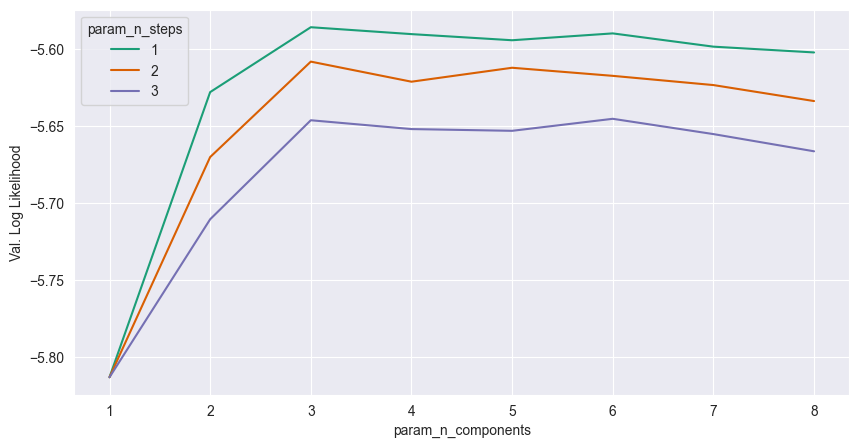

In [75]:
sns.set_style("darkgrid")
sns.lineplot(data=results, x='param_n_components', y='Val. Log Likelihood',
             hue='param_n_steps', palette='Dark2')

In [76]:
results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])

In [77]:
# Same model and grid as above
model.fit(X, y)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 10.30it/s, max_LL=-1.12e+4, max_avg_LL=-5.62]


StepMix(random_state=42)

In [78]:
for g in ParameterGrid(grid):
    model = StepMix(n_components=g['n_components'],
                    n_steps=['n_steps'],
                    measurement='bernoulli',
                    verbose=0, structural='gaussian_unit',
                    random_state=42)
    model.set_params(**g)
    model.fit(X, y)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(X, y))
    results['bic'].append(model.bic(X, y))

Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 125.33it/s, max_LL=-1.16e+4, max_avg_LL=-5.81]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 200.71it/s, max_LL=-8.18e+3, max_avg_LL=-4.09]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 200.53it/s, max_LL=-1.16e+4, max_avg_LL=-5.81]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████| 1/1 [00:00<00:00, 250.78it/s, max_LL=-8.18e+3, max_avg_LL=-4.09]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  9.31it/s, max_LL=-1.12e+4, max_avg_LL=-5.62]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  4.63it/s, max_LL=-8.05e+3, max_avg_LL=-4.02]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 34.38it/s, max_LL=-1.13e+4, max_avg_LL=-5.65]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  5.66it/s, max_LL=-8.05e+3, max_avg_LL=-4.02]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  7.02it/s, max_LL=-1.11e+4, max_avg_LL=-5.57]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.67it/s, max_LL=-8.02e+3, max_avg_LL=-4.01]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 26.59it/s, max_LL=-1.12e+4, max_avg_LL=-5.59]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.79it/s, max_LL=-8.02e+3, max_avg_LL=-4.01]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:01<00:00,  1.63s/it, max_LL=-1.11e+4, max_avg_LL=-5.57]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.16it/s, max_LL=-8.01e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 13.55it/s, max_LL=-1.12e+4, max_avg_LL=-5.58]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  1.06it/s, max_LL=-8.01e+3, max_avg_LL=-4.01]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:02<00:00,  2.05s/it, max_LL=-1.11e+4, max_avg_LL=-5.57]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.03it/s, max_LL=-8.01e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 14.50it/s, max_LL=-1.12e+4, max_avg_LL=-5.58]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.08it/s, max_LL=-8.01e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:02<00:00,  2.06s/it, max_LL=-1.11e+4, max_avg_LL=-5.56]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.08it/s, max_LL=-8.01e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 15.16it/s, max_LL=-1.12e+4, max_avg_LL=-5.58]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.05it/s, max_LL=-8.01e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:02<00:00,  2.17s/it, max_LL=-1.11e+4, max_avg_LL=-5.56]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.02it/s, max_LL=-8.01e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00, 10.60it/s, max_LL=-1.12e+4, max_avg_LL=-5.59]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:01<00:00,  1.01s/it, max_LL=-8.01e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:02<00:00,  2.20s/it, max_LL=-1.11e+4, max_avg_LL=-5.56]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:00<00:00,  1.09it/s, max_LL=-8.01e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  4.80it/s, max_LL=-1.12e+4, max_avg_LL=-5.59]


Fitting StepMix...


Initializations (n_init) : 100%|█████████████████████████| 1/1 [00:01<00:00,  1.02s/it, max_LL=-8.01e+3, max_avg_LL=-4]
C:\Python311\Lib\site-packages\stepmix\stepmix.py:968: ConvergenceWarning: Initializations did not converge. Try different init parameters, or increase max_iter, abs_tol, rel_tol or check for degenerate data.
  warnings.warn(


In [79]:
# Save results to a dataframe
results = pd.DataFrame(results)

On peut aussi utiliser l'AIC et le BIC qui pénalise respectivement pour le
nombre de paramètres et pour le nombre de paramètres et la taille
d'échantillon. Ici le sens est renversé, plus le AIC/BIC est bas,
plus l'ajustement est bon.

<Axes: xlabel='param_n_components', ylabel='aic'>

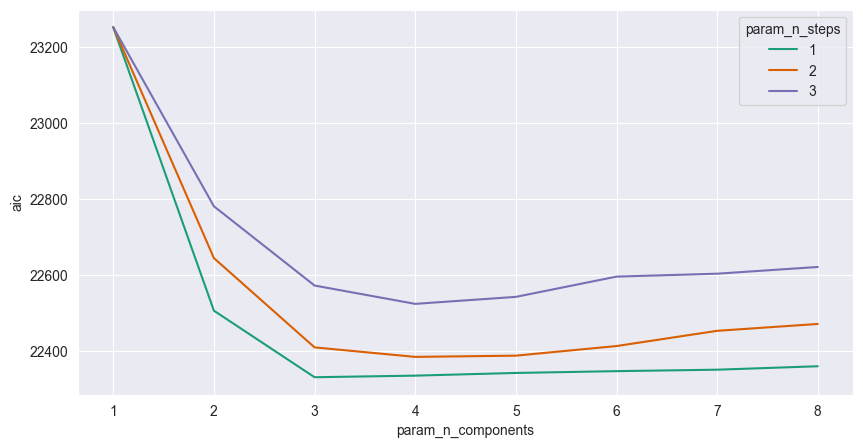

In [80]:
# AIC
sns.lineplot(data=results, x='param_n_components', y='aic',
             hue='param_n_steps', palette='Dark2')

<Axes: xlabel='param_n_components', ylabel='bic'>

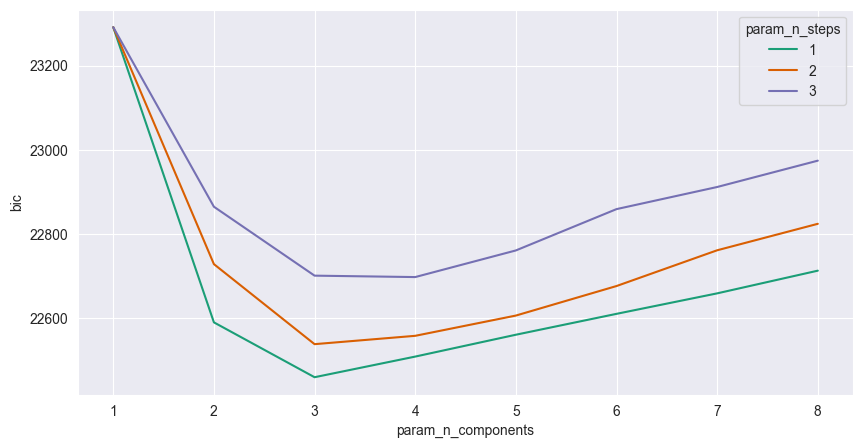

In [81]:
# BIC
sns.lineplot(data=results, x='param_n_components', y='bic',
             hue='param_n_steps', palette='Dark2')

# 10. Extraction des paramètres.

On simule à nouveau des données selon l'article de Szusza Bakk.

In [82]:
X, y, _ = data_bakk_response(n_samples=2000, sep_level=.7,
                             random_state=42)

On ajuste le modèle et on l'ajuste au modèle.

In [83]:
model = StepMix(n_components=3, n_steps=1, measurement='bernoulli',
                structural='gaussian_unit', random_state=42)
model.fit(X, y)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████████| 1/1 [00:00<00:00,  8.85it/s, max_LL=-1.11e+4, max_avg_LL=-5.57]


StepMix(n_components=3, random_state=42)

In [84]:
# On peut extraire les paramètres.
params = model.get_parameters()

In [85]:
# Probabilité *a priori* d'appartenir à chacun des trois groupes.
params['weights']

array([0.33505159, 0.33027011, 0.3346783 ])

In [86]:
# On peut extraire le type de mesure. 'pis' réfère à la probabilité dans
# chaque classe. 
params['measurement'].keys()

dict_keys(['pis'])

In [87]:
# On peut afficher les probabilités
# Les colonnes réfèrent aux 6 outcomes binaires et les rangées aux 3 groupes.
params['measurement']['pis']

array([[0.69573356, 0.69699495, 0.75109648, 0.28641261, 0.28570128,
        0.29089344],
       [0.68607   , 0.68985958, 0.70470246, 0.6828529 , 0.73503231,
        0.73649619],
       [0.29522365, 0.34101623, 0.3140382 , 0.2913577 , 0.23011988,
        0.2892121 ]])

# 11. Apply bootstrap to estimate parameter variances

In [88]:
# On simule à nouveau des données basées sur l'article de Szusza Bakk.
X, y, _ = data_bakk_response(n_samples=2000, sep_level=.9,
                             random_state=42)

In [89]:
# On propose un modèle de mesure dichotomique avec variable dépendante
# normale.
model = StepMix(n_components=3, n_steps=1, measurement='bernoulli',
                structural='gaussian_unit', random_state=42, verbose=0,
                max_iter=2000)
model.fit(X, y)
model.get_parameters()

Fitting StepMix...


Initializations (n_init) : 100%|████████████████████████| 1/1 [00:00<00:00, 20.35it/s, max_LL=-8.6e+3, max_avg_LL=-4.3]


{'weights': array([0.34012133, 0.33543272, 0.32444596]),
 'measurement': {'pis': array([[0.90284622, 0.89961344, 0.8978031 , 0.11564527, 0.07558648,
          0.1003871 ],
         [0.09282214, 0.10440355, 0.10244424, 0.08324981, 0.08847852,
          0.09617739],
         [0.90242198, 0.91078934, 0.90392518, 0.8992002 , 0.90342576,
          0.90799456]])},
 'measurement_in': 6,
 'structural': {'means': array([[ 0.95994108],
         [-0.03792948],
         [-1.01526769]])},
 'structural_in': 1}

In [90]:
# On effectue 1000 échantillon boostrap de nos valeurs.
bs_params = model.bootstrap_stats(X, y, n_repetitions=1000)


Bootstrapping estimator...


Bootstrap Repetitions    : 100%|█| 1000/1000 [01:02<00:00, 15.93it/s, max_LL=-8.36e+3, median_LL=-8.59e+3, min_LL=-9.43
C:\Python311\Lib\site-packages\stepmix\stepmix.py:1173: FutureWarning: The provided callable <function mean at 0x0000020BFF8A56C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  return pd.pivot_table(
C:\Python311\Lib\site-packages\stepmix\stepmix.py:1173: FutureWarning: The provided callable <function std at 0x0000020BFF8A5800> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'std' instead.
  return pd.pivot_table(
C:\Python311\Lib\site-packages\stepmix\stepmix.py:1173: FutureWarning: The provided callable <function mean at 0x0000020BFF8A56C0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used dire

J'extrait les index pour comprendre les paramètres que l'on peut
extraire:
   1) Les pis probabilités d'un 1 pour les 6 outcomes par groupe,
   2) les probabilités d'appartenir à chacun des groupes et
   3) les moyennes de la variable y dans chaque groupe.

In [91]:
level_header = ['model', 'model_name', 'param', 'class_no', 'variable']
bs_params['samples'].sort_index(level=level_header).index.unique()

MultiIndex([('measurement',        'binary',           'pis', 0, 'feature_0'),
            ('measurement',        'binary',           'pis', 0, 'feature_1'),
            ('measurement',        'binary',           'pis', 0, 'feature_2'),
            ('measurement',        'binary',           'pis', 0, 'feature_3'),
            ('measurement',        'binary',           'pis', 0, 'feature_4'),
            ('measurement',        'binary',           'pis', 0, 'feature_5'),
            ('measurement',        'binary',           'pis', 1, 'feature_0'),
            ('measurement',        'binary',           'pis', 1, 'feature_1'),
            ('measurement',        'binary',           'pis', 1, 'feature_2'),
            ('measurement',        'binary',           'pis', 1, 'feature_3'),
            ('measurement',        'binary',           'pis', 1, 'feature_4'),
            ('measurement',        'binary',           'pis', 1, 'feature_5'),
            ('measurement',        'binary',        

Les probabilités d'obtenir un 1 dans chaque colonne de X pour
chaque groupe sont extraites (meanX).
Il s'agit de la partie mesure qui détermine les groupes.

In [92]:
meanX = bs_params['samples'].xs('pis', level=2)[["value"]]

On prépare deux fonctions utiles pour estimer la statistique z (mean/se)
et la p-value. Ces fonctions serviront à construire les tableaux de
coefficients.

In [93]:
def z(x):
    """Calculate z-statistic : mean / se."""
    return x.mean() / x.std()

In [94]:
def pval(x):
    """Calculate the p-value."""
    return np.round(2*norm.cdf(-np.abs(x.mean() / x.std())), 4)

On estime la moyenne, l'erreur-type, la valeur Z et la p-value associée
des probabilités d'obtenir un 1 sur les 6 colonnes de X (meanX).

In [95]:
meanX_table = meanX.groupby(['class_no', 'variable']).agg(
    {'value': ['mean', 'std', z, pval]})
meanX_table

value                             
                        mean       std          z    pval
class_no variable                                        
0        feature_0  0.902958  0.014349  62.929460  0.0000
         feature_1  0.899161  0.016574  54.251759  0.0000
         feature_2  0.898227  0.014934  60.144534  0.0000
         feature_3  0.116642  0.027868   4.185511  0.0000
         feature_4  0.077514  0.042747   1.813300  0.0698
         feature_5  0.101749  0.040449   2.515487  0.0119
1        feature_0  0.094186  0.022950   4.103871  0.0000
         feature_1  0.104972  0.023336   4.498279  0.0000
         feature_2  0.103307  0.022414   4.609026  0.0000
         feature_3  0.082925  0.011338   7.313767  0.0000
         feature_4  0.088105  0.011144   7.905741  0.0000
         feature_5  0.096930  0.011428   8.481997  0.0000
2        feature_0  0.902613  0.012301  73.376108  0.0000
         feature_1  0.910781  0.011714  77.749827  0.0000
         feature_2  0.904202  0.012180  74.235841  0.0000
         feature_3  0.899011  0.013144  68.395816  0.0000
         feature_4  0.903377  0.013336  67.740072  0.0000
         feature_5  0.908339  0.012626  71.944345  0.0000

Pour aider à la compréhension, on peut afficher les moyennes et les se sur
un graphique.

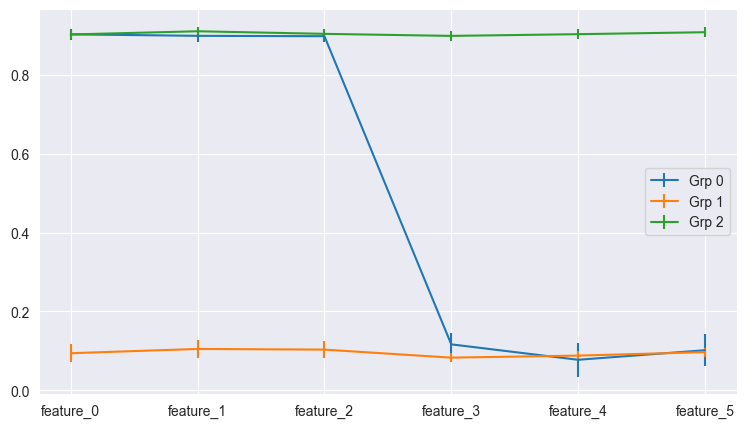

In [96]:
meanX_table = meanX_table.reset_index()
fig, ax = plt.subplots(figsize=(9, 5))
for i in [0, 1, 2]:
    mi = meanX_table[meanX_table['class_no'] == i]
    plt.errorbar(mi['variable'], mi.value['mean'], mi.value['std'],
                 label='Grp ' + str(i))
plt.legend()
plt.show()

J'extrais maintenant les probabilités d'appartenance.

In [97]:
prob = bs_params['samples'].xs('class_weights', level=2)[["value"]]
prob_table = prob.groupby(['class_no']).agg(
    {'value': ['mean', 'std', z, pval]})
prob_table

value                          
              mean       std          z pval
class_no                                    
0         0.340027  0.017239  19.723881  0.0
1         0.335870  0.018806  17.860189  0.0
2         0.324104  0.011542  28.080595  0.0

In [98]:
# Finalement, on peut extraire les moyennes de y dans chaque groupe.
struct = bs_params['samples'].xs('structural')[["value"]]
struct.groupby(['class_no']).agg(
    {'value': ['mean', 'std', z, pval]})

value                            
              mean       std          z   pval
class_no                                      
0         0.956310  0.127055   7.526738  0.000
1        -0.037266  0.045714  -0.815194  0.415
2        -1.015095  0.039379 -25.777731  0.000

Comme tel, il n'y a pas d'intérêt au tableau précédent. On est plutôt
intéressé à la différence des moyennes entre les groupes.
0 vs 1, 0 vs 2 et 1 vs 2.

In [99]:
struct = struct.reset_index()

In [100]:
struct_ctr = pd.DataFrame()

In [102]:
for i in np.arange(0, 2):
    for j in np.arange(i+1, 3):
        si = struct[struct['class_no'] == i][['value']].reset_index(drop=True)
        sj = struct[struct['class_no'] == j][['value']].reset_index(drop=True)
        struct_ctr['G{}_G{}'.format(i, j)] = sj - si

In [103]:
struct_ctrs = pd.DataFrame({"value": struct_ctr.stack()})

In [104]:
# On peut voir que les contrastes sont tous significatifs.
# Les groupes discriminent bien la variable y.
struct_ctrs.groupby(level=1).agg(
    {'value': ['mean', 'std', z, pval]})

value                          
           mean       std          z pval
G0_G1 -0.993576  0.154214  -6.442820  0.0
G0_G2 -1.971404  0.136771 -14.413954  0.0
G1_G2 -0.977828  0.059006 -16.571628  0.0